In [4]:
import torch
from torch import optim
from networks import DeepSurv, NegativeLogLikelihood, SurvivalDataset
from torch.optim.lr_scheduler import LambdaLR
#from lifelines.utils import concordance_index
import numpy as np
import os

In [8]:
from models.modeling_irene import IRENE, CONFIGS
model = IRENE(CONFIGS["IRENE"], 224, zero_head=True, num_classes=8)
# print summary
print(model)

IRENE(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (cc_embeddings): Linear(in_features=768, out_features=768, bias=True)
      (lab_embeddings): Linear(in_features=1, out_features=768, bias=True)
      (sex_embeddings): Linear(in_features=1, out_features=768, bias=True)
      (age_embeddings): Linear(in_features=1, out_features=768, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (dropout_cc): Dropout(p=0.3, inplace=False)
      (dropout_lab): Dropout(p=0.3, inplace=False)
      (dropout_sex): Dropout(p=0.3, inplace=False)
      (dropout_age): Dropout(p=0.3, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-1): 2 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (att_norm_text): LayerNorm((768,), eps=1e-06, eleme

In [15]:
device = torch.device("cuda")
drop = 0.5
norm = True
dims = [53, 20, 10, 1]
activation = 'SELU'
l2_reg = 0
lr = 3e-2
lr_decay_rate = 3e-3
model = DeepSurv(drop, norm, dims, activation).to(device)
criterion = NegativeLogLikelihood(l2_reg).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train_dataset = SurvivalDataset("/data/home/penghy/UKB/data/digestive/survival_train.csv")
test_dataset = SurvivalDataset("/data/home/penghy/UKB/data/digestive/survival_test.csv")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20000)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20000)
lambda_f = lambda epoch: lr / (1+epoch*lr_decay_rate)
scheduler = LambdaLR(optimizer, lr_lambda=lambda_f)
best_c_index = 0
flag = 0
patience = 40

In [16]:
def c_index(risk_pred, y, e):
    if not isinstance(y, np.ndarray):
        y = y.detach().cpu().numpy()
    if not isinstance(risk_pred, np.ndarray):
        risk_pred = risk_pred.detach().cpu().numpy()
    if not isinstance(e, np.ndarray):
        e = e.detach().cpu().numpy()
    return concordance_index(y, risk_pred, e)

In [17]:
print(model)

DeepSurv(
  (model): Sequential(
    (0): Linear(in_features=53, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=10, out_features=1, bias=True)
    (9): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SELU()
  )
)


In [18]:
def train():
    global best_c_index
    for epoch in range(1,501):
        model.train()
        for x, e, t in train_loader:
            x=x.to(device=device)
            e=e.to(device=device)
            t=t.to(device=device)
            risk_pred = model(x)
            train_loss = criterion(risk_pred, t, e, model)
            optimizer.zero_grad()
            train_loss.backward()
            train_c = c_index(-risk_pred, t, e)
            optimizer.step()
        scheduler.step()
        model.eval()
        for x, e, t in test_loader:
            x=x.to(device=device)
            e=e.to(device=device)
            t=t.to(device=device)
            with torch.no_grad():
                risk_pred = model(x)
                valid_loss = criterion(risk_pred, t, e, model)
                valid_c = c_index(-risk_pred, t, e)
                if best_c_index < valid_c:
                    best_c_index = valid_c
                    flag = 0
                    # saves the best model
                    torch.save({
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'epoch': epoch}, os.path.join("./model/", 'model'+str(epoch)+'.pth'))
                else:
                    flag += 1
                    if flag >= patience:
                        return best_c_index
        lr = lambda_f(epoch)
        print('\rEpoch: {}\tLoss: {:.8f}({:.8f})\tc-index: {:.8f}({:.8f})\tlr: {:g}'.format(
            epoch, train_loss.item(), valid_loss.item(), train_c, valid_c, lr), end='', flush=False)
    return best_c_index

In [19]:
best_c_index = train()

Epoch: 44	Loss: -1334.26696777(-389.32299805)	c-index: 0.62857997(0.66596696)	lr: 0.0265018

In [20]:
best_c_index

0.6671534179063612

In [1]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("/data/home/penghy/UKB/data/digestive/survival_liver.csv")

In [4]:
train_data = train_data.iloc[:,1:56]

In [5]:
train_data.columns

Index(['31', '48', '49', '738', '806', '816', '826', '845', '864', '884',
       '904', '1050', '1060', '1070', '1080', '1090', '1160', '1289', '1299',
       '1309', '1319', '1930#1', '1940#1', '1950#1', '1970#1', '1980#1',
       '2020#1', '20116', '20117', '21000#1', '21000#2', '21000#3', '21000#4',
       '21000#5', '21000#6', '21000#1001', '21000#1002', '21000#1003',
       '21000#2001', '21000#2002', '21000#2003', '21000#2004', '21000#3001',
       '21000#3002', '21000#3003', '21000#3004', '21000#4001', '21000#4002',
       '21000#4003', '21001', '21022', '23099', '26410', 'event', 'time'],
      dtype='object')

In [3]:
train = train_data.drop(labels=['21000#2', '21000#3', '21000#4'], axis=1)

In [51]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(train, duration_col='time', event_col='event')

<lifelines.CoxPHFitter: fitted with 502466 total observations, 462892 right-censored observations>

In [52]:
pr = cph.summary

In [53]:
cph.concordance_index_

0.6790682748287882

<Axes: xlabel='log(HR) (95% CI)'>

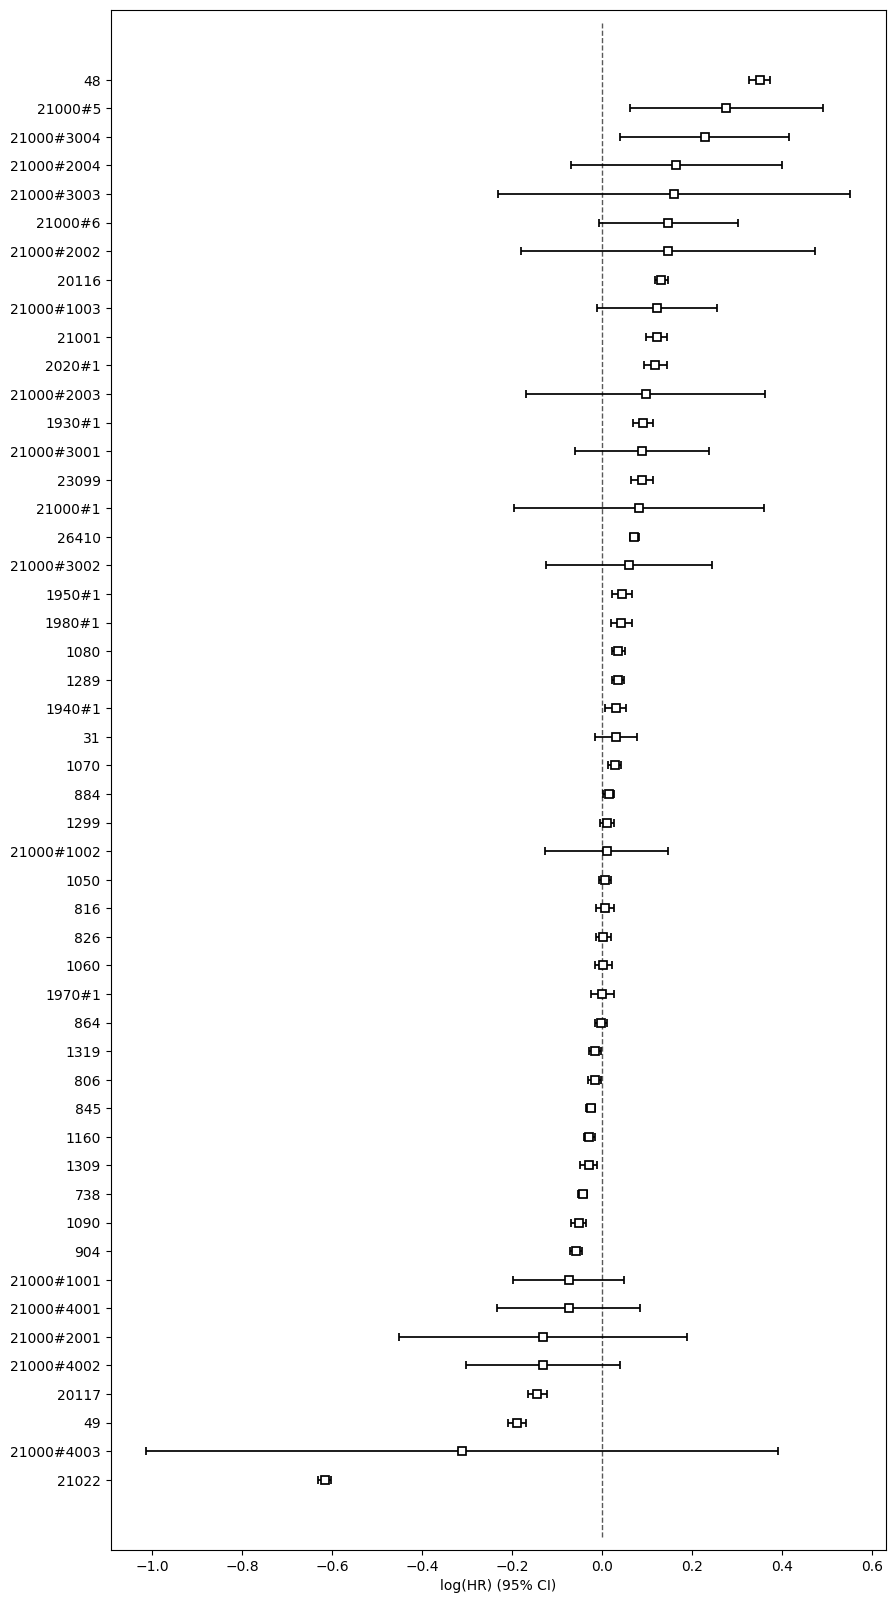

In [54]:
plt.figure(figsize=(10,20))
cph.plot()

In [55]:
pr

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
31,0.030316,1.030780,0.023974,-0.016672,0.077303,0.983466,1.080370,0.0,1.264534,2.060386e-01,2.279014
48,0.350580,1.419891,0.011792,0.327467,0.373693,1.387450,1.453090,0.0,29.729432,3.199181e-194,642.776348
49,-0.189543,0.827338,0.009871,-0.208889,-0.170196,0.811485,0.843500,0.0,-19.202147,3.551077e-82,270.569847
738,-0.043415,0.957514,0.005121,-0.053453,-0.033377,0.947951,0.967174,0.0,-8.476990,2.310951e-17,55.264291
806,-0.016900,0.983242,0.007314,-0.031235,-0.002564,0.969247,0.997439,0.0,-2.310540,2.085828e-02,5.583236
816,0.006239,1.006258,0.010286,-0.013921,0.026399,0.986176,1.026750,0.0,0.606568,5.441375e-01,0.877957
826,0.002755,1.002758,0.008164,-0.013247,0.018756,0.986840,1.018933,0.0,0.337398,7.358165e-01,0.442582
845,-0.025245,0.975071,0.005134,-0.035308,-0.015183,0.965308,0.984932,0.0,-4.917232,8.777655e-07,20.119661
864,-0.002281,0.997722,0.007027,-0.016053,0.011492,0.984075,1.011558,0.0,-0.324579,7.455000e-01,0.423720


In [4]:
subdat = train.loc[:,['48','49','738','904','1930#1','2020#1','20116','20117','21001','21022','23099','26410','event','time']]

In [5]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(subdat, duration_col='time', event_col='event')

<lifelines.CoxPHFitter: fitted with 502466 total observations, 462892 right-censored observations>

In [6]:
cph.concordance_index_

0.6775097650665566

In [7]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
48,0.361681,1.435741,0.009720,0.342630,0.380733,1.408648,1.463356,0.0,37.209434,4.802874e-303,1004.280315
49,-0.197505,0.820776,0.009732,-0.216579,-0.178431,0.805269,0.836582,0.0,-20.294627,1.434383e-91,301.775026
738,-0.055383,0.946123,0.004787,-0.064766,-0.046000,0.937287,0.955042,0.0,-11.568544,5.948364e-31,100.407278
904,-0.054075,0.947361,0.006340,-0.066501,-0.041648,0.935662,0.959207,0.0,-8.528836,1.478270e-17,55.908868
1930#1,0.119909,1.127395,0.010796,0.098749,0.141070,1.103789,1.151505,0.0,11.106384,1.167932e-28,92.790030
2020#1,0.140337,1.150661,0.012873,0.115105,0.165568,1.121992,1.180064,0.0,10.901278,1.136494e-27,89.507469
20116,0.140586,1.150948,0.007379,0.126124,0.155048,1.134423,1.167714,0.0,19.052610,6.250647e-81,266.432170
20117,-0.156918,0.854774,0.010001,-0.176519,-0.137317,0.838183,0.871694,0.0,-15.690824,1.747731e-55,181.900562
21001,0.123700,1.131676,0.011968,0.100243,0.147157,1.105439,1.158536,0.0,10.335789,4.853988e-25,80.769032


In [8]:
from time_dependent_roc import time_depend_roc

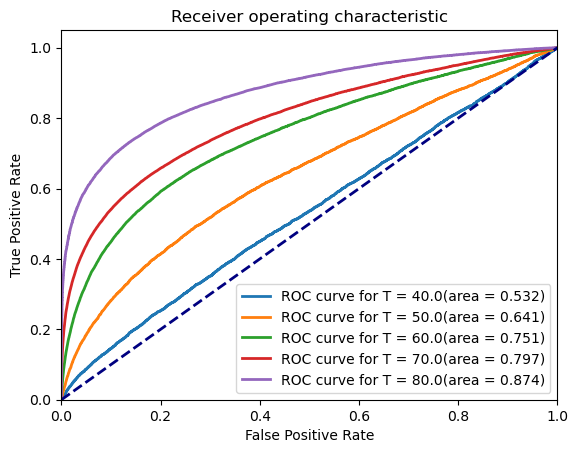

0

In [12]:
risk_pred = cph.predict_partial_hazard(subdat.iloc[:,0:12])
e = subdat['event']
t = subdat['time']
time_depend_roc(risk_pred,e,t,[40,50,60,70,80],"ROC")